Using new data produces with pandas and cleaned version

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import VAE_processing


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Loading the trained VAE

In [3]:
vae_lsst_r_band_conv, vae_r_utils, encoder_R, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v21/bis_bis/mse/',1, folder = True)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v12/bis2/',6, folder= True) # v7 OK

In [5]:
vae_lsst_euclid_conv,vae_lsst_euclid_utils, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v9/bis2/mse/',10, folder = True)

# Load data

In [6]:
data_dir = "/sps/lsst/users/barcelin/data/single_galaxies/test/"
root = 'galaxies_isolated_20191022_0'

In [7]:
images = np.load(data_dir+'galaxies_isolated_20191022_0_images.npy', mmap_mode = 'c')

In [9]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [10]:
list_of_samples=[data_dir+'galaxies_isolated_20191022_0_images.npy']

# Generators

In [11]:
bands_r = [6]

In [17]:
batch_gen_r = generator.BatchGenerator(bands_r, list_of_samples, total_sample_size=len(list_of_samples[0]),
                               batch_size= 100, trainval_or_test = 'training',
                               do_norm = True, denorm = False, list_of_weights_e = None)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [18]:
bands_lsst = [4,5,6,7,8,9]

In [19]:
batch_gen_lsst = generator.BatchGenerator(bands_lsst, list_of_samples,total_sample_size=len(list_of_samples[0]),
                                batch_size= 100, trainval_or_test = 'test',
                                do_norm = True, denorm = False, list_of_weights_e = None)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


In [20]:
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [21]:
batch_gen_lsst_euclid = generator.BatchGenerator(bands_lsst_euclid, list_of_samples,total_sample_size=len(list_of_samples[0]), 
                                       batch_size= 100,  trainval_or_test = 'test', 
                                       do_norm = True, denorm =False,list_of_weights_e = None)

[BatchGenerator] total_sample_size =  10000
[BatchGenerator] len(list_of_samples) =  1


# Parameters to fix

In [22]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Test plot vae R band only

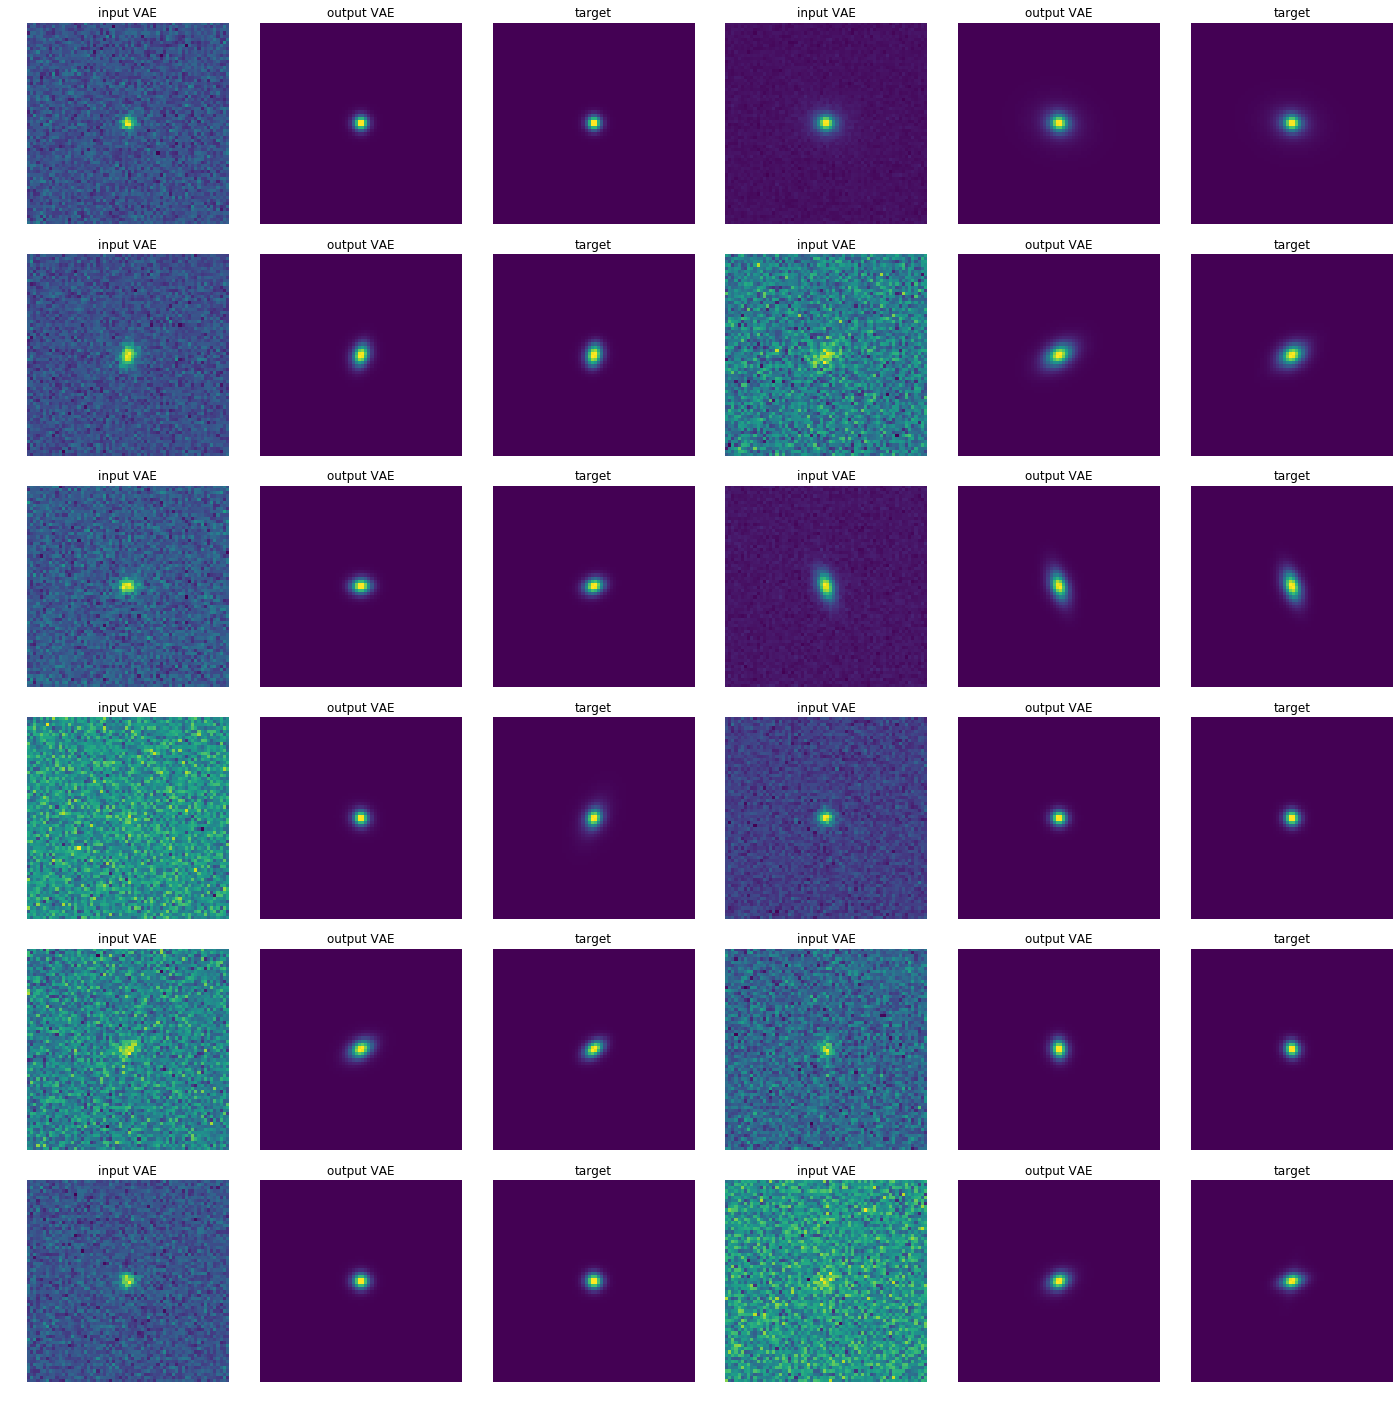

In [24]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_r.__getitem__(2)
output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_r, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_r, channel_last = True)
output_vae = denorm(output_vae, bands_r, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]].reshape((64,64)))

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

# Test plot for LSST all filters

In [25]:
stamp_size_plot = int(stamp_size /2)

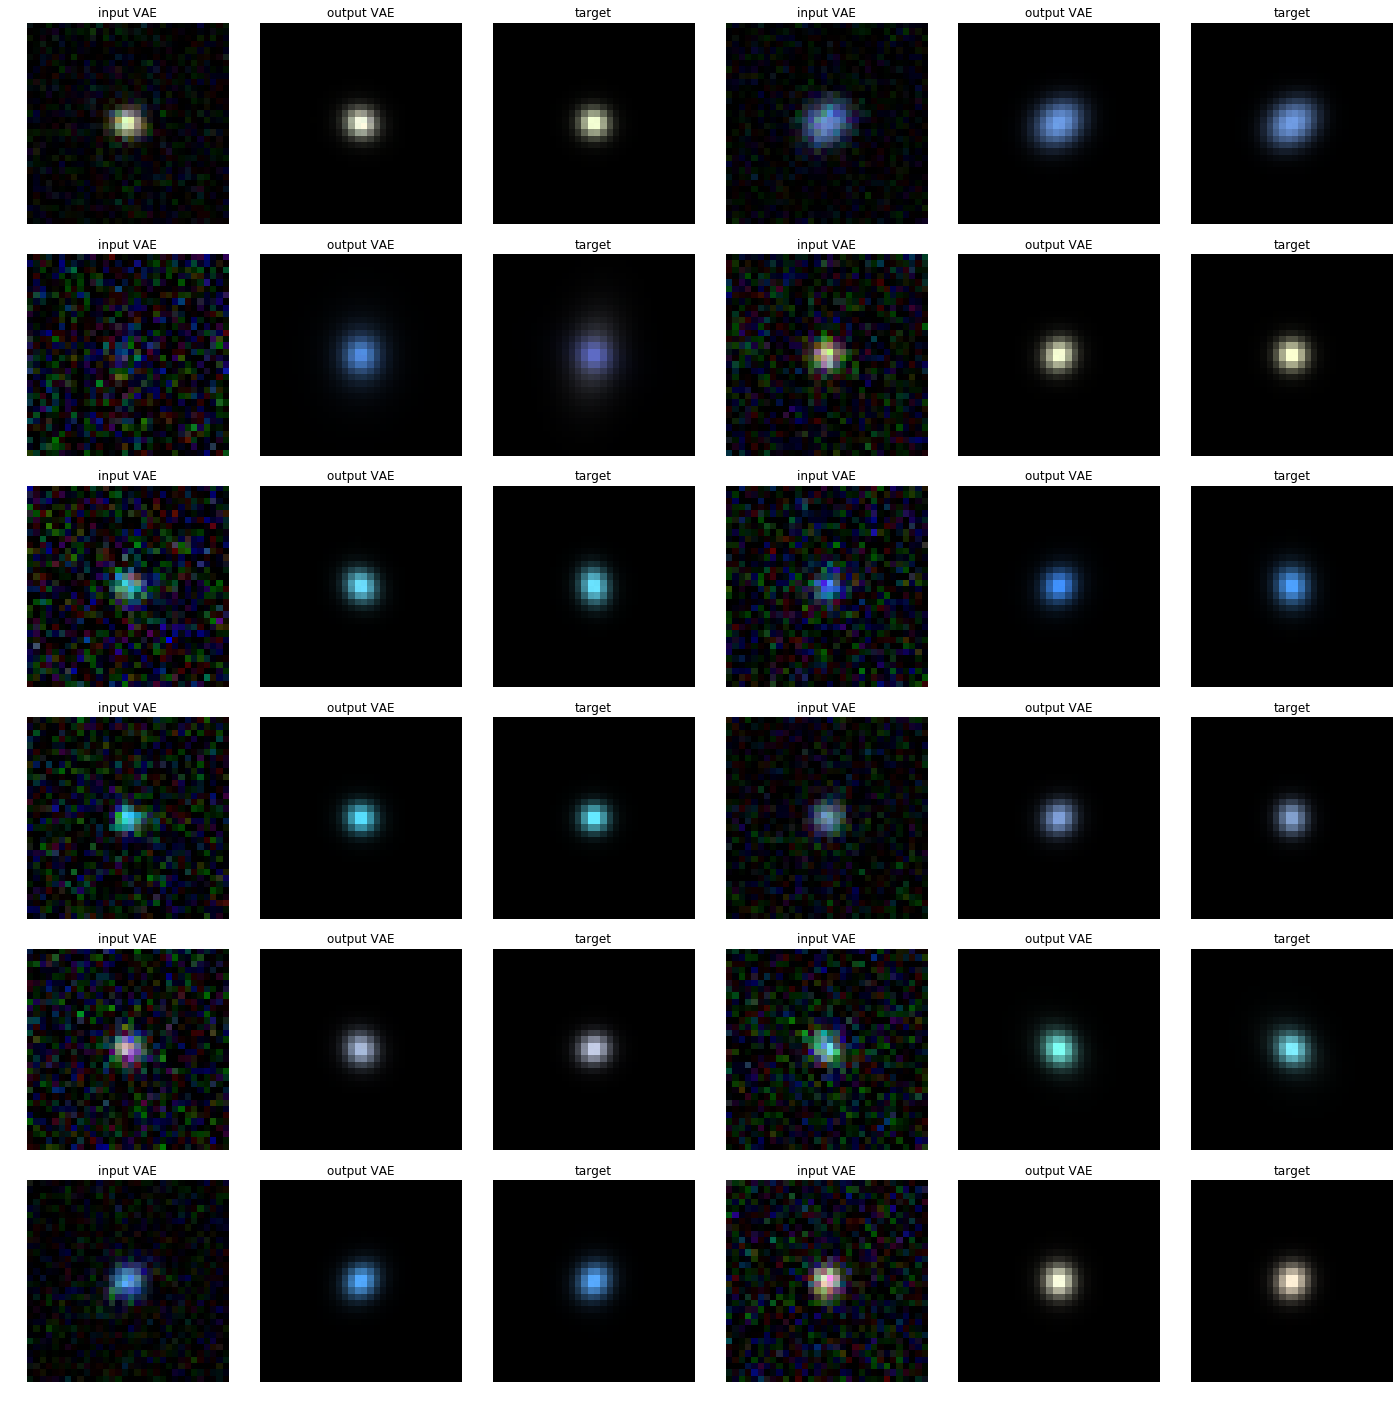

In [26]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst.__getitem__(2)
output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
output_vae = denorm(output_vae, bands_lsst, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot.plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size_plot, axes[i,j])
        plot.plot_rgb_lsst(output_vae[indices[i*N_plot+j]], stamp_size_plot, axes[i,j+1])
        plot.plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size_plot, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

# Test plot for LSST+Euclid filters

In [27]:
stamp_size_plot = int(stamp_size /2)

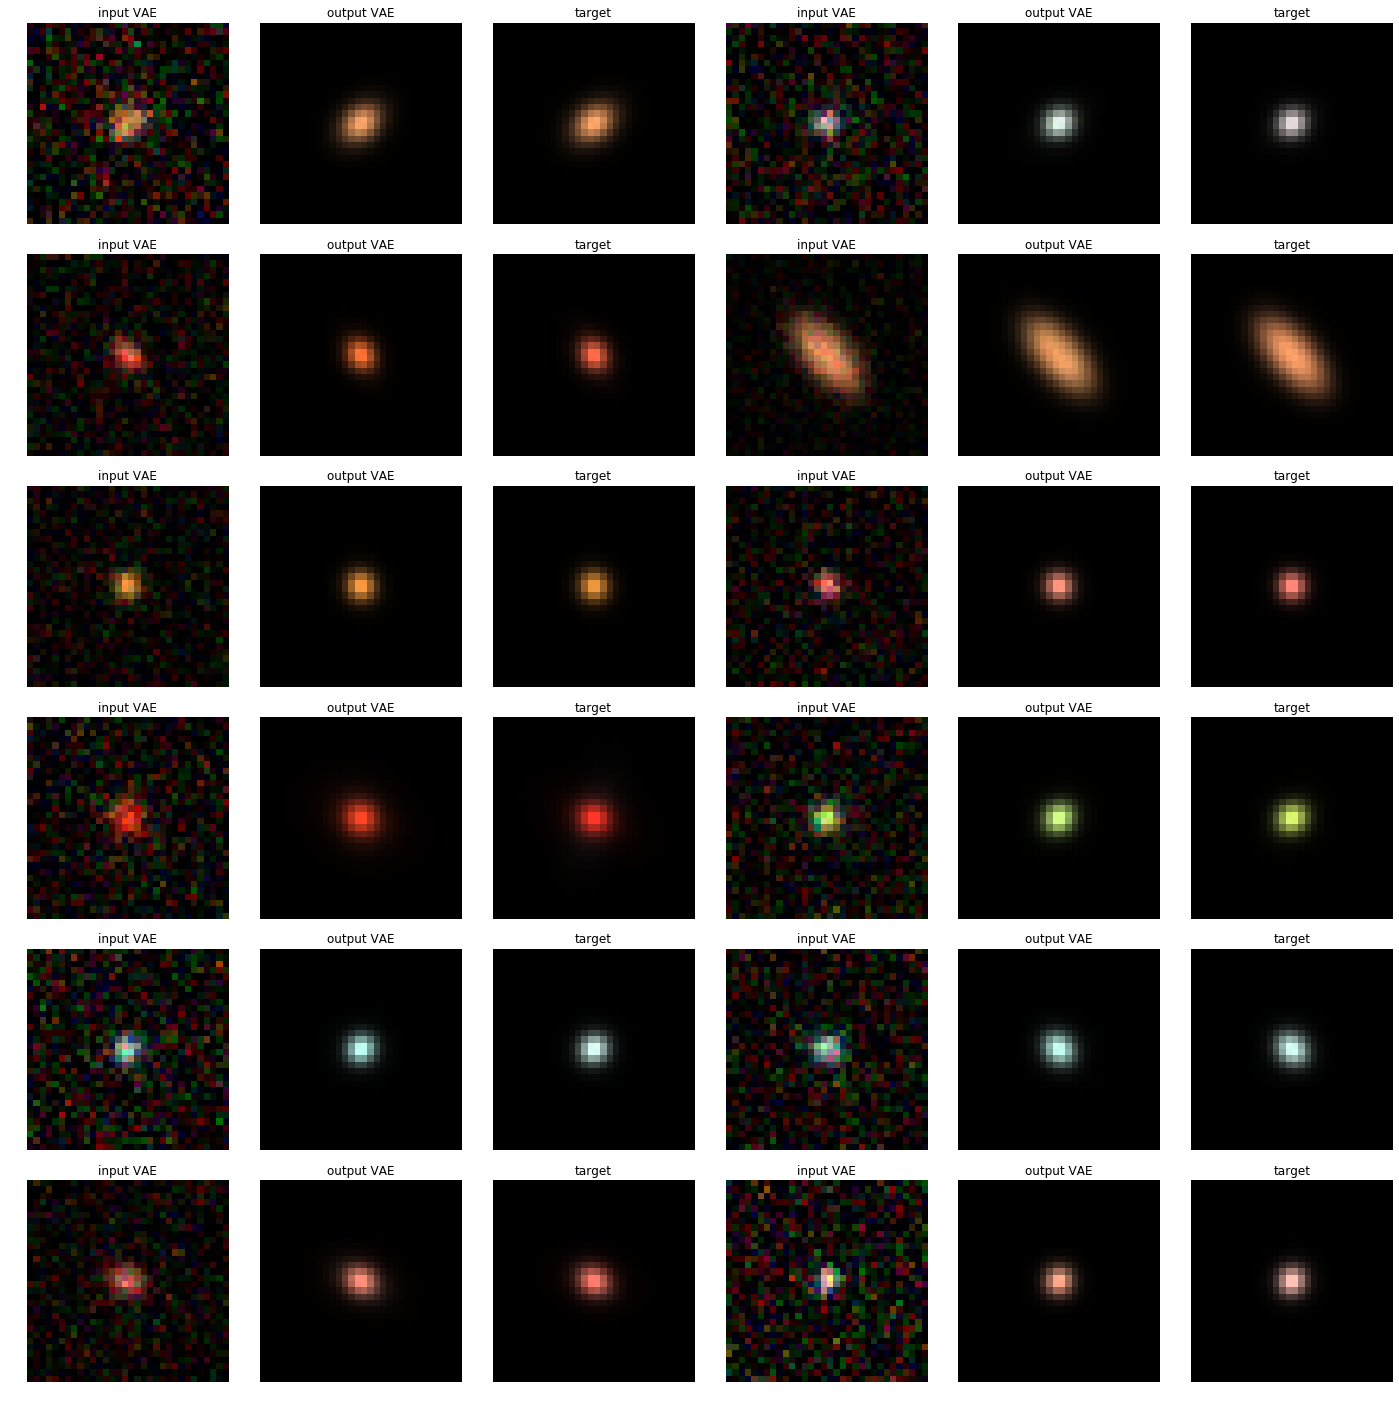

In [28]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst_euclid.__getitem__(2)
output_vae = vae_lsst_euclid_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst_euclid, channel_last = True)
output_vae = denorm(output_vae, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):

        plot.plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]], stamp_size_plot, axes[i,j])
        plot.plot_rgb_lsst_euclid(output_vae[indices[i*N_plot+j]], stamp_size_plot, axes[i,j+1])
        plot.plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]], stamp_size_plot, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')